# Quickstart: NOAA GEFS forecast - dynamical.org zarr
A brief introduction to the NOAA GEFS forecast dataset transformed into an analysis ready, cloud optimized format by dynamical.org.

A description of this dataset and more information can be found in the dataset calalog: https://dynamical.org/catalog/noaa-gefs-forecast/.


In [ ]:
# Install the xarray[complete] dependency required for this example. If you're not using pip
# to install depdencies (for example, you're using conda or uv), skip this cell and install 
# xarray[complete] using the package manager of your choice.
%pip install xarray[complete]

In [18]:
import xarray as xr

ds = xr.open_zarr("https://data.dynamical.org/noaa/gefs/forecast/latest.zarr?email=optional@email.com")
ds

<xarray.Dataset> Size: 185TB
Dimensions:                                         (init_time: 408,
                                                     ensemble_member: 31,
                                                     lead_time: 181,
                                                     latitude: 721,
                                                     longitude: 1440)
Coordinates:
  * ensemble_member                                 (ensemble_member) uint16 62B ...
    expected_forecast_length                        (init_time) timedelta64[ns] 3kB dask.array<chunksize=(408,), meta=np.ndarray>
    ingested_forecast_length                        (init_time, ensemble_member) timedelta64[ns] 101kB dask.array<chunksize=(408, 31), meta=np.ndarray>
  * init_time                                       (init_time) datetime64[ns] 3kB ...
  * latitude                                        (latitude) float64 6kB 90...
  * lead_time                                       (lead_time) timedelta64[ns] 1kB ...
  * longitude                                       (longitude) float64 12kB ...
    spatial_ref                                     int64 8B ...
    valid_time                                      (init_time, lead_time) datetime64[ns] 591kB dask.array<chunksize=(408, 181), meta=np.ndarray>
Data variables: (12/34)
    categorical_freezing_rain_surface               (init_time, ensemble_member, lead_time, latitude, longitude) float32 10TB dask.array<chunksize=(1, 31, 181, 73, 72), meta=np.ndarray>
    categorical_freezing_rain_surface_avg           (init_time, lead_time, latitude, longitude) float32 307GB dask.array<chunksize=(1, 181, 146, 144), meta=np.ndarray>
    categorical_ice_pellets_surface                 (init_time, ensemble_member, lead_time, latitude, longitude) float32 10TB dask.array<chunksize=(1, 31, 181, 73, 72), meta=np.ndarray>
    categorical_ice_pellets_surface_avg             (init_time, lead_time, latitude, longitude) float32 307GB dask.array<chunksize=(1, 181, 146, 144), meta=np.ndarray>
    categorical_rain_surface                        (init_time, ensemble_member, lead_time, latitude, longitude) float32 10TB dask.array<chunksize=(1, 31, 181, 73, 72), meta=np.ndarray>
    categorical_rain_surface_avg                    (init_time, lead_time, latitude, longitude) float32 307GB dask.array<chunksize=(1, 181, 146, 144), meta=np.ndarray>
    ...                                              ...
    wind_u_100m                                     (init_time, ensemble_member, lead_time, latitude, longitude) float32 10TB dask.array<chunksize=(1, 31, 181, 73, 72), meta=np.ndarray>
    wind_u_10m                                      (init_time, ensemble_member, lead_time, latitude, longitude) float32 10TB dask.array<chunksize=(1, 31, 181, 73, 72), meta=np.ndarray>
    wind_u_10m_avg                                  (init_time, lead_time, latitude, longitude) float32 307GB dask.array<chunksize=(1, 181, 146, 144), meta=np.ndarray>
    wind_v_100m                                     (init_time, ensemble_member, lead_time, latitude, longitude) float32 10TB dask.array<chunksize=(1, 31, 181, 73, 72), meta=np.ndarray>
    wind_v_10m                                      (init_time, ensemble_member, lead_time, latitude, longitude) float32 10TB dask.array<chunksize=(1, 31, 181, 73, 72), meta=np.ndarray>
    wind_v_10m_avg                                  (init_time, lead_time, latitude, longitude) float32 307GB dask.array<chunksize=(1, 181, 146, 144), meta=np.ndarray>
Attributes:
    attribution:          NOAA NWS NCEP GEFS data processed by dynamical.org ...
    dataset_id:           noaa-gefs-forecast
    description:          Weather forecasts from the Global Ensemble Forecast...
    forecast_domain:      Forecast lead time 0-840 hours (0-35 days) ahead
    forecast_resolution:  Forecast step 0-240 hours: 3 hourly, 243-840 hours:...
    name:                 NOAA GEFS forecast
    spatial_domain:       Global
    spatial_resol

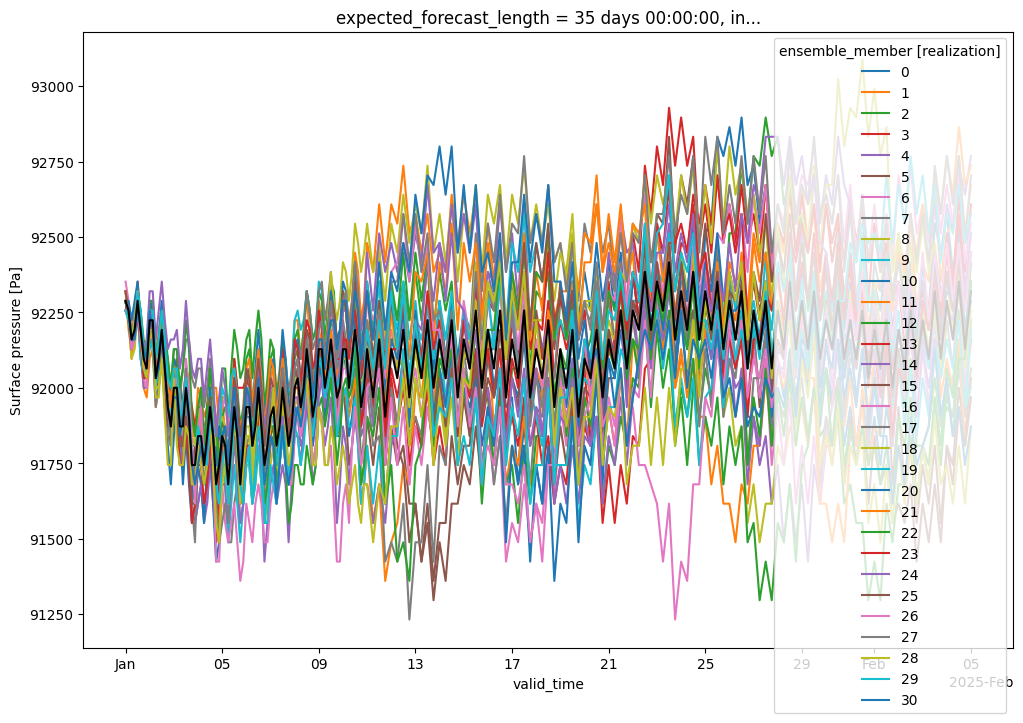

In [ ]:
# Plot the ensemble traces of the 2025-01-01 forecast at a point on the earth
plot_ds = ds.sel(init_time="2025-01-01T00", latitude=-23.5, longitude=-46.6, method="nearest")  # São Paulo, Brazil
plot_ds["pressure_surface"].plot(x="valid_time", hue="ensemble_member", figsize=(12, 8))
plot_ds["pressure_surface_avg"].plot(x="valid_time", c="black")  # Black line is ensemble average

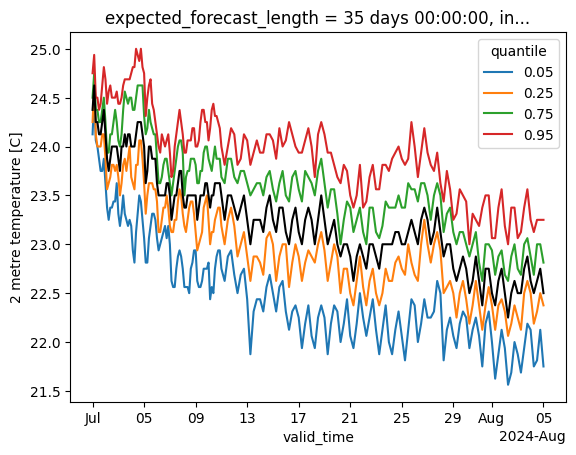

In [20]:
# Plot a summary of the ensemble distribution using quantiles
plot_ds = ds.sel(init_time="2024-07-01T00", latitude=0, longitude=0)
(
    plot_ds["temperature_2m"]
    .quantile([0.05, 0.25, 0.75, 0.95], dim="ensemble_member")
    .plot(x="valid_time", hue="quantile")
)
plot_ds["temperature_2m_avg"].plot(x="valid_time", c="black")

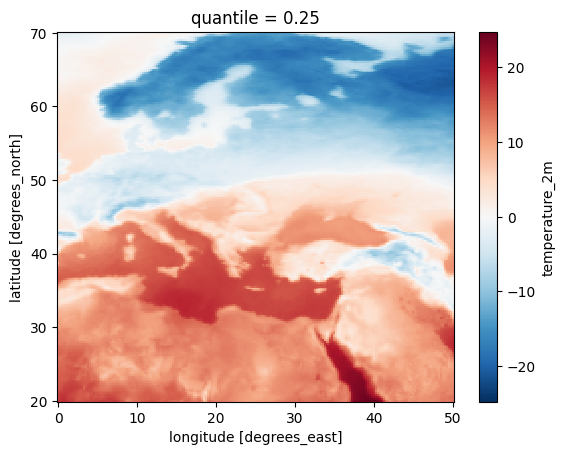

In [24]:
# Calculate a quantile across ensemble members and display the result as a map
(
    ds["temperature_2m"]
    .sel(init_time="2025-01-01T00")
    .sel(lead_time="7d")
    .sel(latitude=slice(70, 20), longitude=slice(0, 50))
    .quantile(0.25, dim="ensemble_member") # 25% chance it gets colder than this
    .plot()
)

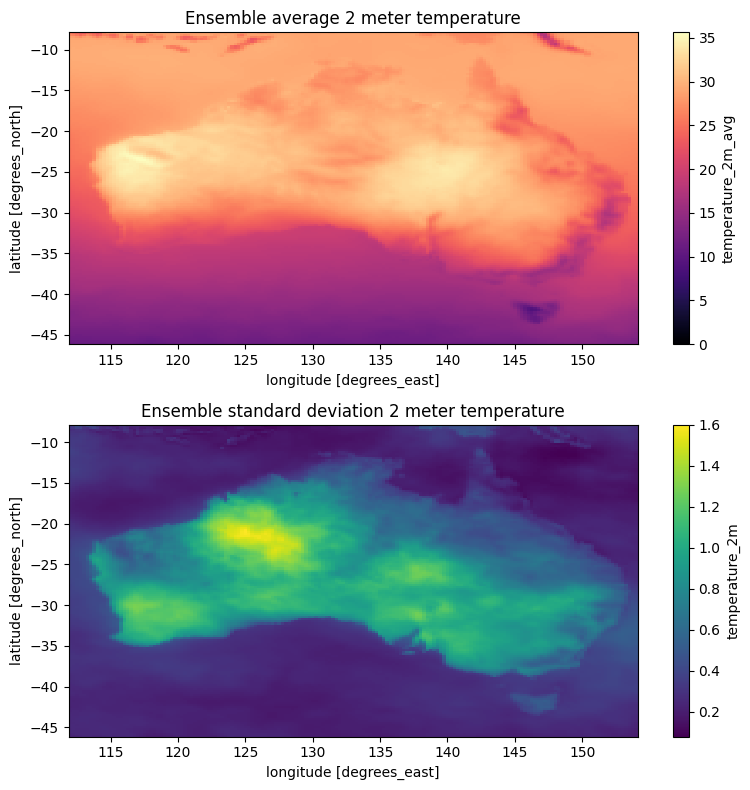

In [22]:
# Areas of highest uncertainty in temperature forecast over the first 7 days of 2025

import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, figsize=(8, 8))

plot_ds = (
    ds.sel(init_time="2024-03-01T00")
    .sel(latitude=slice(-8, -46), longitude=slice(112, 154))  # Australia
    .sel(lead_time=slice("0h", "7d")).mean(dim="lead_time")  # Average the first week of the forecast
)

# Plot the ensemble average for context
plot_ds["temperature_2m_avg"].plot(ax=axes[0], cmap="magma", vmin=0)
axes[0].set_title("Ensemble average 2 meter temperature")

# Standard deviation across ensemble members to highlight regions of forecast uncertainty
plot_ds["temperature_2m"].std(dim="ensemble_member").plot(ax=axes[1])
axes[1].set_title("Ensemble standard deviation 2 meter temperature")

plt.tight_layout()